In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [8]:
from main import *

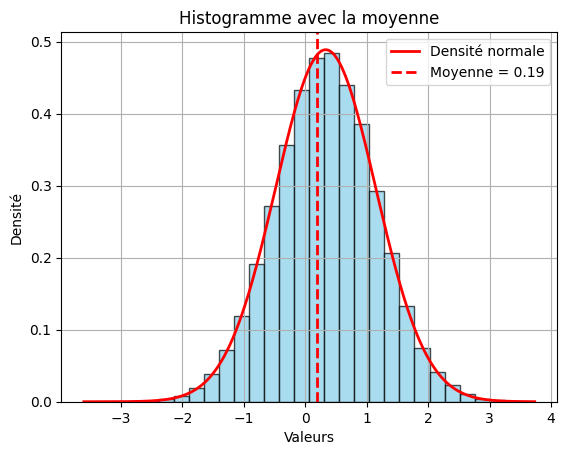

In [31]:
if __name__ == "__main__":
    d = 1  # Dimension
    m = np.ones(d)
    v = 2*np.eye(d)

    x_init = np.random.randn(d)
    n_iter = 100000

    ess_sample = np.array(elliptical_slice_sampling(x_init, m, v, n_iter))
    # Histogramme avec densité (area under histogram = 1)
    plt.hist(ess_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Ligne de densité normale théorique
    l = np.linspace(min(ess_sample), max(ess_sample), n_iter)
    plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Densité normale')

    mean_value = np.mean(samples) 
    # Afficher
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

# Ajouter titre et légende
    plt.title("Histogramme avec la moyenne")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

### Common random number coupling

- One while loop to select always de the same $\theta$

In [64]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2


def coupled_transition(x1, x2, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_p_x1, log_p_x2 = log_likelihood(x1, m, v), log_likelihood(x2, m, v)
    u = np.log(np.random.uniform(0, 1))
    log_y_1 = log_p_x1 + u
    log_y_2 = log_p_x2 + u

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_1, proposal_2 = x1 * np.cos(theta) + w * np.sin(theta),  x2 * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_1, log_p_proposal_2 = log_likelihood(proposal_1, m, v), log_likelihood(proposal_2, m, v)

    while log_p_proposal_1 <= log_y_1 and log_p_proposal_2 <= log_y_2 :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal_1, proposal_2 = x1 * np.cos(theta) + w * np.sin(theta),  x2 * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_1, log_p_proposal_2 = log_likelihood(proposal_1, m, v), log_likelihood(proposal_2, m, v)

    return proposal_1, proposal_2


def coupled_ess(x1, x2, m, v, n_iter):
    samples = [(x1, x2)]
    x, y = x1, x2

    for i in range(1, n_iter + 1):
        x, y = coupled_transition(x, y, m, v)
        samples.append((x, y))

    return samples

- Target : $\pi = \mathcal{N}(\frac{1}{3}, \frac{2}{3})$
- Prior : $\mu_0 = \mathcal{N}(0, 1)$
- likelihood : $\rho(x) \propto \mathcal{N}(x; 1, 2)$

In [65]:
if __name__ == "__main__":
    m, v = 1, 2

    x1, x2 = -10, 10
    n_iter = 10000

    samples = coupled_ess(x1, x2, m, v, n_iter)

In [66]:
x_sample = np.array([samples[i][0] for i in range(len(samples))])
y_sample = np.array([samples[i][1] for i in range(len(samples))])
meet_time = []
for i in range(len(samples)):
    if x_sample[i]==y_sample[i]:
        meet_time.append(i)

- $\texttt{x}$ sample density compared to the target 

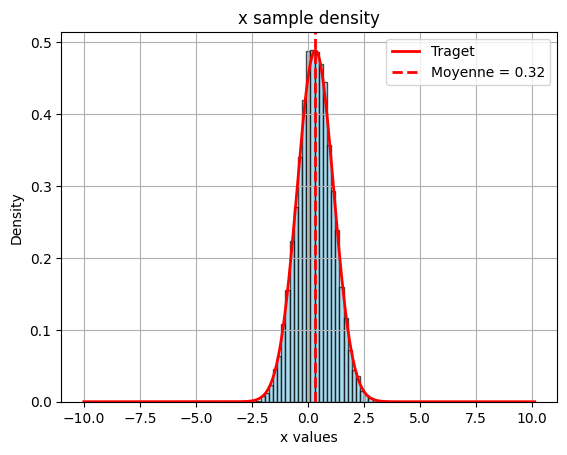

In [67]:
# Histogramme avec densité (area under histogram = 1)
plt.hist(x_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Ligne de densité normale théorique
l = np.linspace(min(x_sample), max(x_sample), n_iter)
plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Traget')

mean_value = np.mean(x_sample) 
    # Afficher
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

plt.title('x sample density')
plt.xlabel('x values')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

- ACF of $\texttt{x}$ sample

<function matplotlib.pyplot.show(close=None, block=None)>

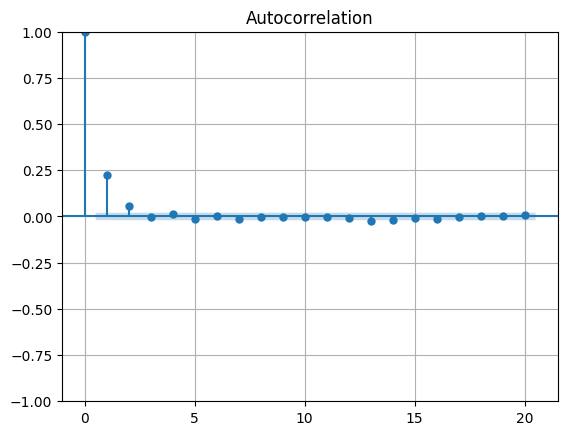

In [68]:
plot_acf(x_sample, lags= 20)
plt.grid()
plt.show

- See if $\texttt{x}$ and $\texttt{y}$ contracts  

/tmp/ipykernel_110664/2546797401.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(x_sample - y_sample)))


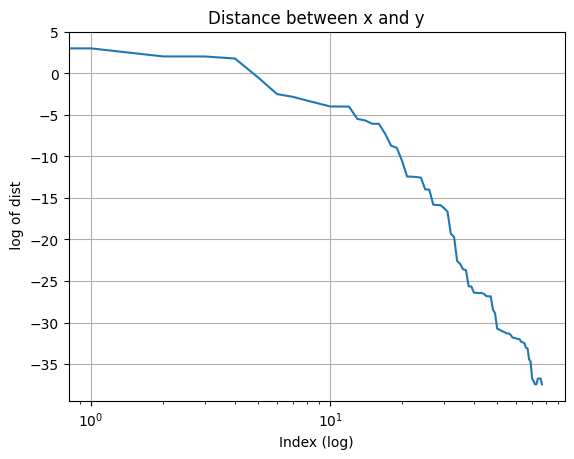

In [69]:
plt.plot(np.log(np.abs(x_sample - y_sample)))
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.title("Distance between x and y")
plt.xlabel("Index (log)")
plt.ylabel(" log of dist")
plt.grid()
plt.show()

In [63]:
samples

[(-10, 10),
 (np.float64(5.444770371136038), np.float64(-3.9144600899430984)),
 (np.float64(2.965395898426616), np.float64(-2.2561739197117263)),
 (np.float64(2.415329689001801), np.float64(-1.8017650856218648)),
 (np.float64(2.400034109833992), np.float64(-1.80508703931384)),
 (np.float64(-1.6571175289874012), np.float64(0.9086762492994651)),
 (np.float64(-1.4940528050228052), np.float64(0.026694997429836498)),
 (np.float64(-1.3507224798263364), np.float64(0.1498128374486069)),
 (np.float64(-1.1279776012027323), np.float64(-0.5611708494613428)),
 (np.float64(-1.2096329692756311), np.float64(-0.6777859697553336)),
 (np.float64(1.292383365510186), np.float64(0.7662365450474347)),
 (np.float64(1.1389949066685863), np.float64(0.6183939118528015)),
 (np.float64(-0.281634939696733), np.float64(-0.22816608516651188)),
 (np.float64(0.10423195052921885), np.float64(0.15681991972314221)),
 (np.float64(1.8812179848324015), np.float64(1.8890639069566897)),
 (np.float64(-0.6794396271417463), np.fl

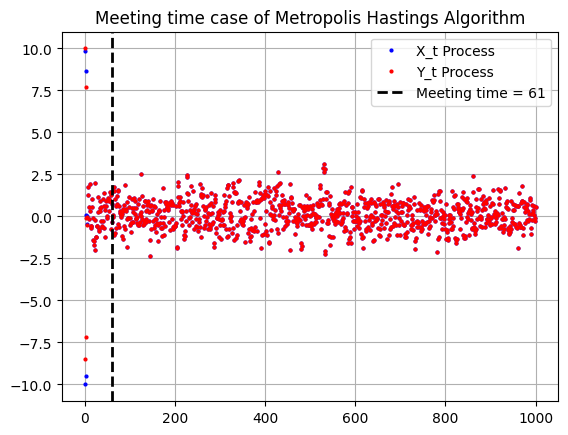

In [12]:
x = np.arange(len(samples))
plt.plot(x, x_sample, marker='o', linestyle='None', markersize=2, color='blue', label = 'X_t Process')
plt.plot(x, y_sample, marker='o', linestyle='None', markersize=2, color='red', label = 'Y_t Process')
plt.axvline(meet_time[0], color='black', linestyle='dashed', linewidth=2, label=f'Meeting time = {meet_time[0]}')
plt.title("Meeting time case of Metropolis Hastings Algorithm")
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [03:13<00:00, 25.81it/s]


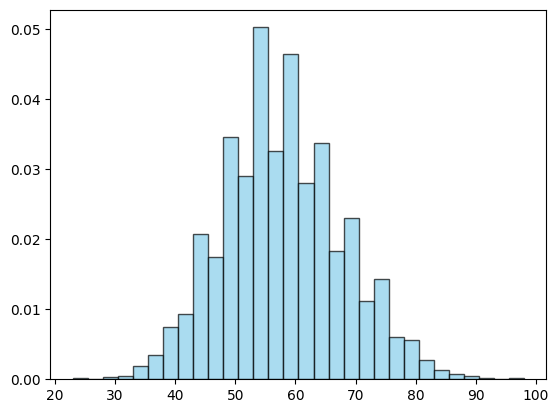

In [8]:
if __name__ == "__main__":
    m, v = 1, 2

    x1, x2 = -1, 1
    n_iter = 1000
    N = 5000

    meet_time = []

    for _ in tqdm(range(N)):
        samples = coupled_ess(x1, x2, m, v, n_iter)
        x_sample = np.array([samples[i][0] for i in range(len(samples))])
        y_sample = np.array([samples[i][1] for i in range(len(samples))])
        i = 0
        while x_sample[i] != y_sample[i]:
            i += 1
        meet_time.append(i)
    
    plt.hist(meet_time, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

- Two while loops to have different decisions meaning possibly different $\theta$

In [6]:
def coupled_transition(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_px, log_py = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_proposal_x = log_likelihood(proposal_1, m, v)

    theta_visited = [theta]
    while log_p_proposal_x <= log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood(proposal_1, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_proposal_y = log_likelihood(proposal_y, m, v)

    counter = 0
    while log_p_proposal_y <= log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood(proposal_y, m, v) 

    return proposal_x, proposal_y


def coupled_ess(x0, y0, m, v, n_iter):
    samples = [(x0, y0)]
    x, y = x0, y0

    for i in range(1, n_iter + 1):
        x, y = coupled_transition(x, y, m, v)
        samples.append((x, y))

    return samples

### Logistic Regression case (density shifting)

### Transition distribution

In [ ]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

def transition(x, m, v):
    """
    One step of Elliptical Slice Sampling (ESS)
    
    Parameters:
        x (np.ndarray): Current state
        m (np.ndarray): Mean of Gaussian target
        v (np.ndarray): Covariance of Gaussian target
        
    Returns:
        np.ndarray: New sample from the ESS transition
    """

    w = np.random.normal(0, 1)  # w ~ N(0, I)
    
    log_p_x = log_likelihood(x, m, v)
    log_y = log_p_x + np.log(np.random.uniform(0, 1))  # Slice threshold

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal = log_likelihood(proposal, m, v)

    # Shrinkage loop
    while log_p_proposal <= log_y:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal = log_likelihood(proposal, m, v)

    return proposal

100%|██████████| 50000/50000 [00:01<00:00, 40777.21it/s]


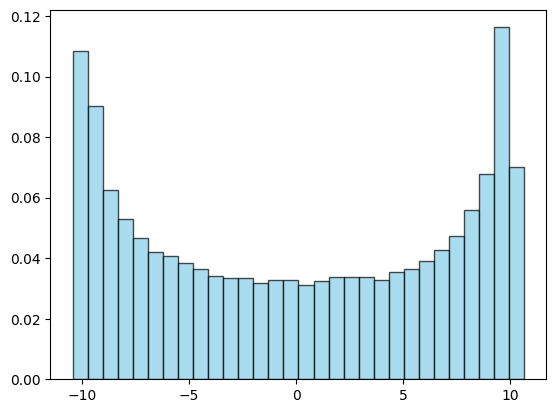

In [ ]:
if __name__ == "__main__":
    m, v = 1, 2
    x = -10
    N = 50000
    
    sample = [transition(x, m, v) for _ in tqdm(range(N))]
    plt.hist(sample, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

In [15]:
print(np.mean(np.array(sample)), np.std(np.array(sample)))

0.044903005904007316 7.073517437771719


- Interpolation between a uniform and a Normal distribution 